In [1]:
import csv
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook, tqdm

/home/alexis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Dans ce notebook, j'utilise des embeddings pré-entrainés pour être capable de faire de l'analyse du langage. Ils peuvent être téléchargés ici : https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec.

`EMBEDDING_FILE_PATH` doit pointer vers l'endroit où se trouve les embeddings sur votre machine.

In [2]:
EMBEDDING_FILEPATH = '/home/alexis/mva/word_embeddings/wiki.fr.vec'
WORD_EMBEDDING_SIZE = 300
FILE_NAME = './data/fiscalite.json'

Chargement des word embeddings déjà entrainés.

In [3]:
import gensim
from gensim.models import Word2Vec
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILEPATH, binary=False)

On itère sur les différentes contributions.
Pour chaque contribution, on crée un objet contenant le titre de la contribution et les réponses pour chaque question.

In [16]:
answer_frequency = defaultdict(lambda: 0)
questions = dict()
participations = []

In [19]:
with open(FILE_NAME, 'r') as input_file:
    for k in range(10000):
        responses = []
        line = next(input_file)
        participation = json.loads(line)

        assert(len(participation['responses']) == 8)
        responses.append(participation['titre'])

        for response in participation['responses']:
            if response['question']["id"] not in questions:
                questions[response['question']["id"]] = response['question']['title']
            if response['value']:
                answer_frequency[response['question']['title']] += 1
            responses.append(response['value'])
        
        participations.append(responses)

Ici, on construit l'embedding d'une participation.

On construit l'embedding d'une participation comme la moyenne des embeddings de chaque réponse non nulle de la participation (le titre, la réponse à la première question, la réponse à la deuxième question, etc).

On construit l'embedding de chaque réponse comme la moyenne des embeddings de chaque mot reconnu de la réponse.

In [20]:
embeddings = np.zeros((0, WORD_EMBEDDING_SIZE))

for participation in participations:
    participation_embedding = np.zeros((1, WORD_EMBEDDING_SIZE))
    number_of_responses = 0

    for response in participation:
        if response:
            number_of_responses += 1

            words = keras.preprocessing.text.text_to_word_sequence(
                response,
                filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                lower=True,
                split=' '
            )

            sentence_embedding = np.zeros((1, WORD_EMBEDDING_SIZE))

            for word in words:
                try:
                    sentence_embedding += pretrained_embeddings[word.lower()]
                except:
                    pass

            sentence_embedding /= max(len(words), 1)

            participation_embedding += sentence_embedding

    embeddings = np.concatenate((
        embeddings,
        participation_embedding / max(1, number_of_responses)
    ))

In [22]:
embeddings.shape

(40000, 300)

On fait une PCA en dimension 3 pour voir s'il existe des clusters évidents.

In [23]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2', 'principal component 3']
).values

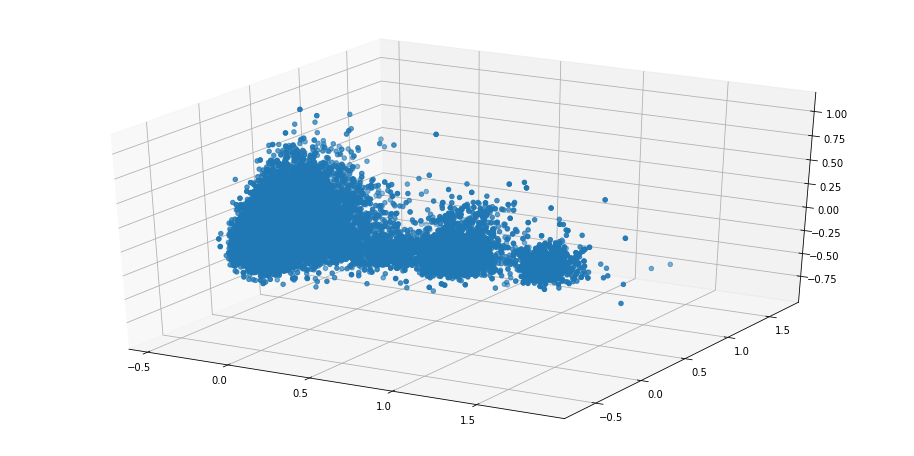

In [24]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalDf[:,0], principalDf[:,1], principalDf[:,2])

In [25]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(
    data=principal_components,
    columns=['principal component 1', 'principal component 2']
).values

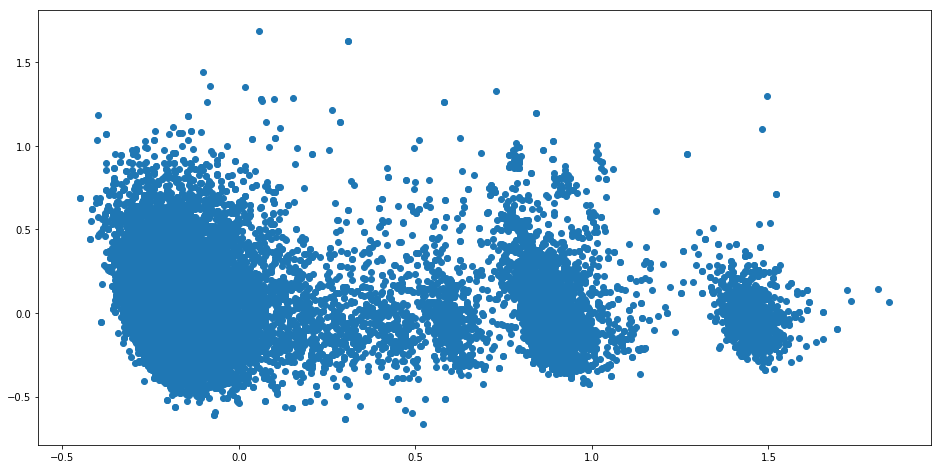

In [26]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.scatter(principalDf[:,0], principalDf[:,1])

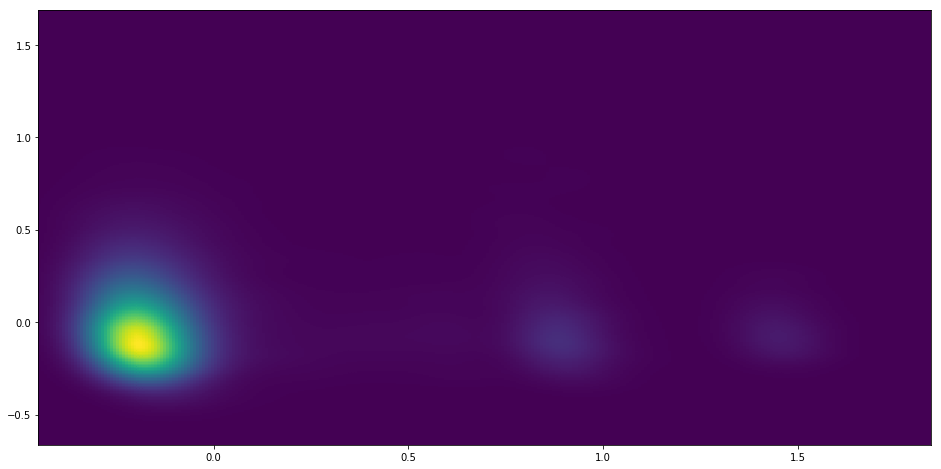

In [27]:
from scipy.stats import kde

nbins=300
x, y = principalDf[:,0], principalDf[:,1]
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Make the plot
fig = plt.figure(figsize=(16, 8))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()